In [1]:
from networks import ConditionGenerator
from train_condition import get_opt

import os
from PIL import Image

import torch
from torch import nn
import numpy as np

import lovely_tensors as lt
lt.monkey_patch()

In [2]:
t =Image.open('/home/aiteam/tykim/generative_model/human/HR-VITON/data/train/image-parse-v3/00000_00.png')

In [3]:
t.mode

'P'

In [4]:
# Dresscode 확인
t =Image.open('/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/label_maps/020714_4.png')

In [5]:
t.mode

'P'

In [68]:
import torchvision.transforms as transforms

In [69]:
tt = transforms.ToTensor()

In [62]:
torch.unique(tt(t))

tensor[21] x∈[0., 0.933] μ=0.441 σ=0.280

In [2]:
opt = get_opt()

In [3]:
opt.output_nc

13

In [6]:
input1_nc = 4  # cloth + cloth-mask
input2_nc = opt.semantic_nc + 3  # parse_agnostic + densepose
checkpoint_path = '/home/aiteam/tykim/generative_model/human/HR-VITON/mtviton.pth'

tocg = ConditionGenerator(opt, input1_nc=4, input2_nc=input2_nc, output_nc=opt.output_nc, ngf=96, norm_layer=nn.BatchNorm2d)
tocg.load_state_dict(torch.load(checkpoint_path), strict=False)

<All keys matched successfully>

In [ ]:
tocg.cuda()

In [9]:
from cp_dataset import CPDataset,CPDatasetTest,CPDataLoader
test_dataset = CPDatasetTest(opt)
loader = CPDataLoader(opt, test_dataset)

/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use I

In [10]:
inputs = loader.next_batch()

In [11]:
# input1
c_paired = inputs['cloth']['paired'].cuda()
cm_paired = inputs['cloth_mask']['paired'].cuda()
cm_paired = torch.FloatTensor((cm_paired.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
# input2
parse_agnostic = inputs['parse_agnostic'].cuda()
densepose = inputs['densepose'].cuda()
openpose = inputs['pose'].cuda()
# GT
label_onehot = inputs['parse_onehot'].cuda()  # CE
label = inputs['parse'].cuda()  # GAN loss
parse_cloth_mask = inputs['pcm'].cuda()  # L1
im_c = inputs['parse_cloth'].cuda()  # VGG
# visualization
im = inputs['image']


/tmp/ipykernel_3218643/386173775.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm_paired = torch.FloatTensor((cm_paired.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()


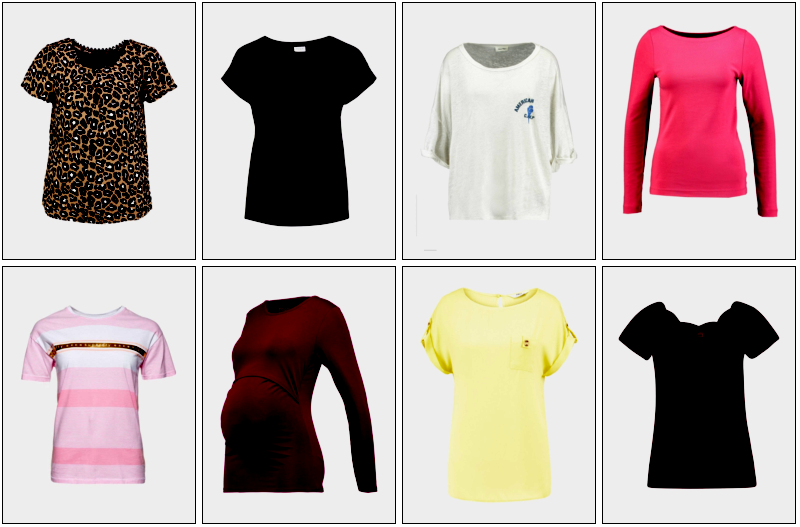

In [12]:
lt.rgb(c_paired)

In [14]:
input1 = torch.cat([c_paired, cm_paired], 1)
input2 = torch.cat([parse_agnostic, densepose], 1)

In [15]:
input1.shape, input2.shape

(torch.Size([8, 4, 256, 192]), torch.Size([8, 16, 256, 192]))

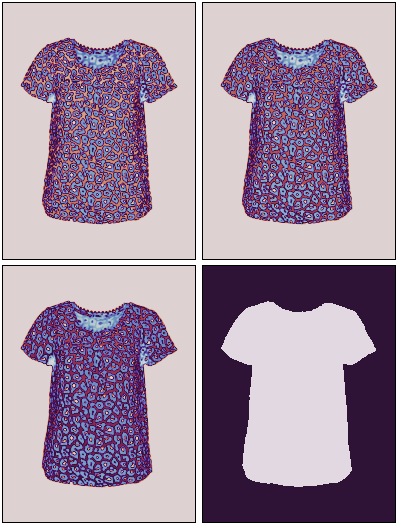

In [16]:
lt.chans(input1[0])

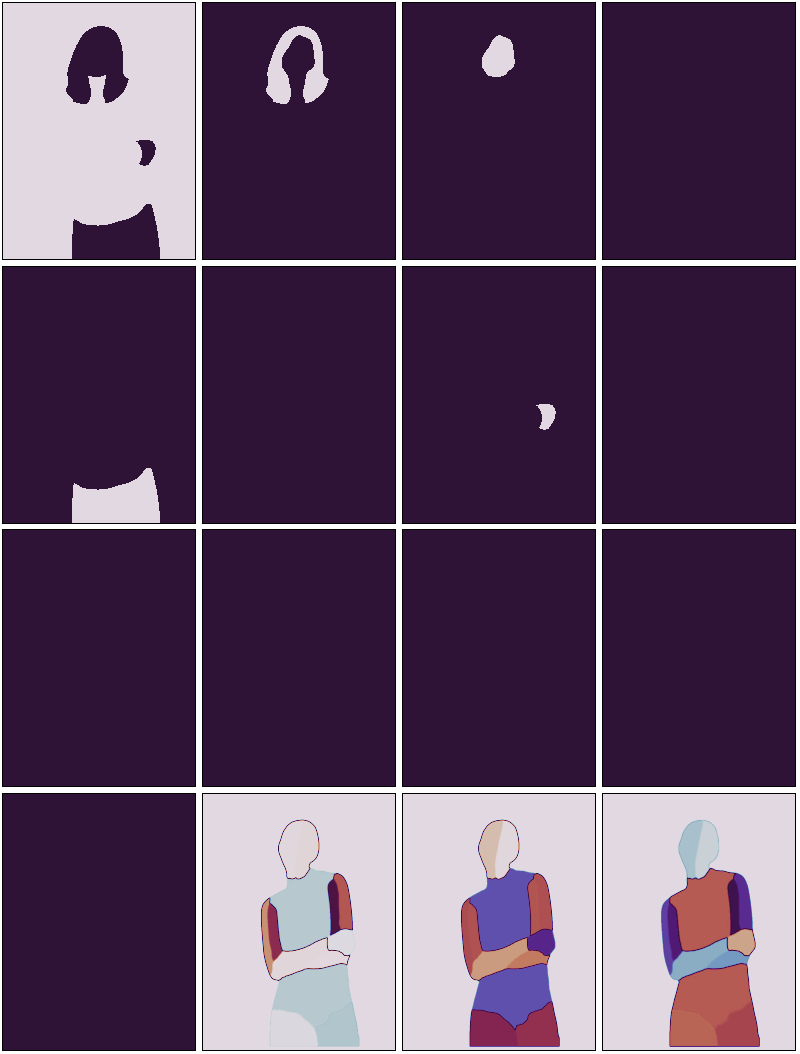

In [17]:
lt.chans(input2[0])

In [18]:
opt.cuda=True

In [19]:
flow_list, fake_segmap, warped_cloth_paired, warped_clothmask_paired = tocg(opt, input1, input2)

/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [33]:
flow_list

[tensor[8, 8, 6, 2] n=768 x∈[-39.947, 69.229] μ=-0.596 σ=13.845 grad PermuteBackward0 cuda:0,
 tensor[8, 16, 12, 2] n=3072 x∈[-34.143, 55.558] μ=-2.469 σ=14.288 grad AddBackward0 cuda:0,
 tensor[8, 32, 24, 2] n=12288 x∈[-35.599, 47.234] μ=-2.248 σ=14.531 grad AddBackward0 cuda:0,
 tensor[8, 64, 48, 2] n=49152 x∈[-48.727, 56.683] μ=-2.506 σ=13.897 grad AddBackward0 cuda:0,
 tensor[8, 128, 96, 2] n=196608 x∈[-55.830, 35.992] μ=-3.370 σ=12.378 grad AddBackward0 cuda:0]

In [34]:
fake_segmap

tensor[8, 13, 256, 192] n=5111808 x∈[0., 31.579] μ=2.505 σ=4.867 grad ReluBackward0 cuda:0

In [35]:
fake_segmap[0][3]

tensor[256, 192] n=49152 x∈[0., 25.507] μ=13.587 σ=3.942 grad SelectBackward0 cuda:0

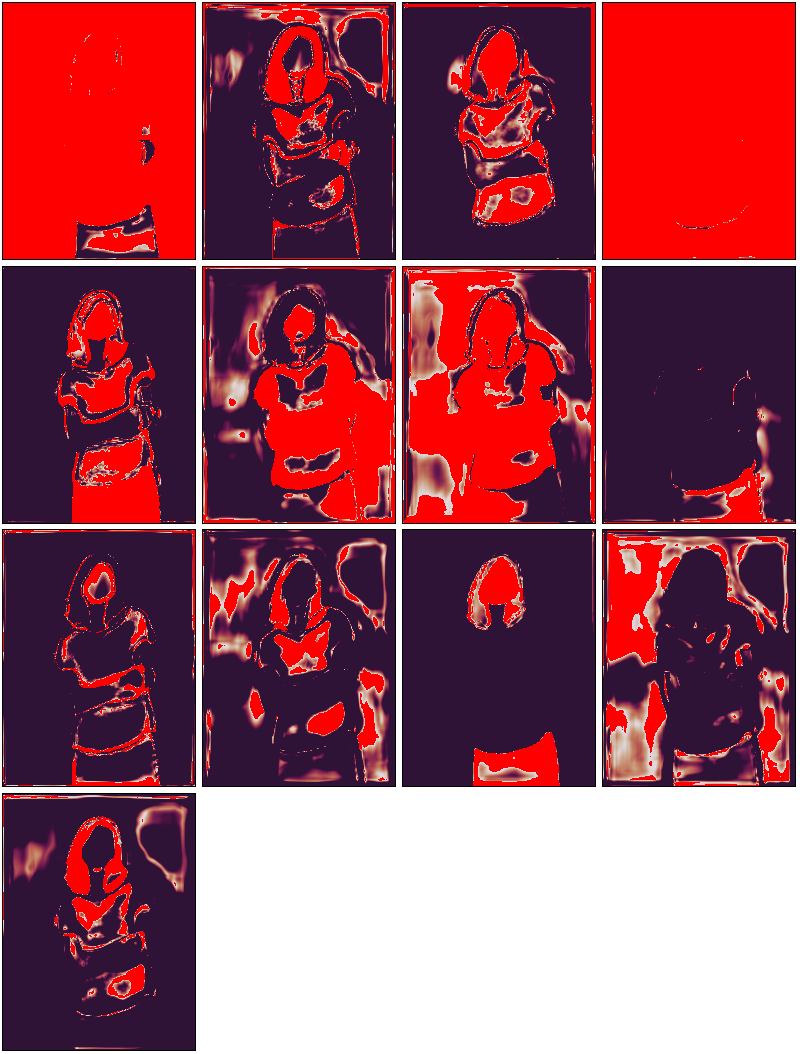

In [36]:
lt.chans(fake_segmap[0])

In [37]:
warped_cloth_paired

tensor[8, 3, 256, 192] n=1179648 x∈[-0.977, 1.000] μ=0.793 σ=0.394 grad SliceBackward0 cuda:0

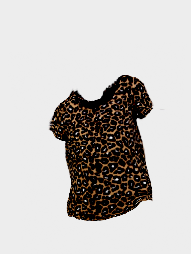

In [38]:
lt.rgb(warped_cloth_paired[0])

In [39]:
warped_clothmask_paired

tensor[8, 1, 256, 192] n=393216 x∈[0., 1.000] μ=0.208 σ=0.405 grad SliceBackward0 cuda:0

In [40]:
opt.clothmask_composition

'warp_grad'

In [41]:
warped_clothmask_paired.shape

torch.Size([8, 1, 256, 192])

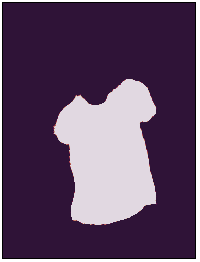

In [42]:
lt.chans(warped_clothmask_paired[0])

In [43]:
cloth_mask = torch.ones_like(fake_segmap.detach())

In [44]:
cloth_mask[:, 3:4, :, :] = warped_clothmask_paired

In [45]:
fake_segmap = fake_segmap * cloth_mask

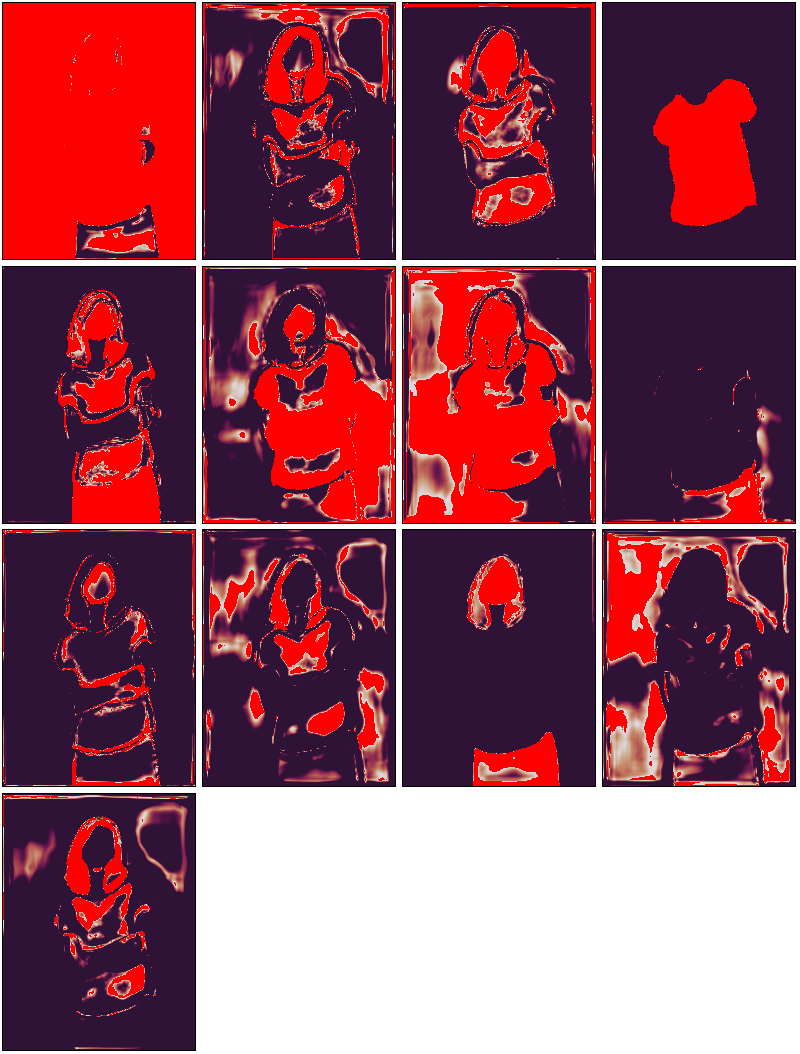

In [46]:
lt.chans(fake_segmap[0])

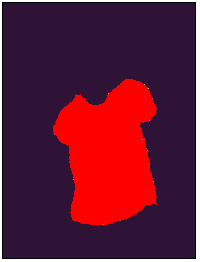

In [51]:
lt.chans(fake_segmap[0][3])

In [52]:
fake_segmap[0][3]

tensor[256, 192] n=49152 x∈[0., 25.507] μ=3.338 σ=6.740 grad SelectBackward0 cuda:0

In [47]:
torch.argmax(fake_segmap.detach(), dim=1, keepdim=True)

tensor[8, 1, 256, 192] i64 n=393216 x∈[0, 6] μ=1.361 σ=1.814 cuda:0

In [48]:
fake_clothmask = (torch.argmax(fake_segmap.detach(), dim=1, keepdim=True) == 3).long()

In [49]:
fake_clothmask.shape

torch.Size([8, 1, 256, 192])

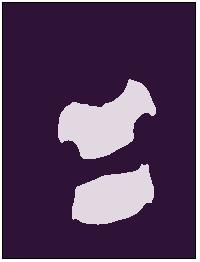

In [50]:
lt.chans(fake_clothmask[0])

In [53]:
warped_cm_onehot = torch.FloatTensor((warped_clothmask_paired.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()

/tmp/ipykernel_3218643/1292200760.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warped_cm_onehot = torch.FloatTensor((warped_clothmask_paired.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()


In [54]:
warped_cm_onehot.shape

torch.Size([8, 1, 256, 192])

In [55]:
torch.unique(warped_cm_onehot)

tensor[2] μ=0.500 σ=0.707 cuda:0 [0., 1.000]

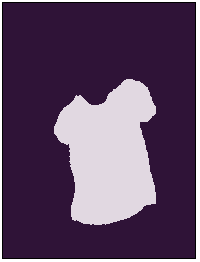

In [56]:
lt.chans(warped_cm_onehot[0])

In [57]:
misalign = fake_clothmask - warped_cm_onehot

In [58]:
misalign.shape

torch.Size([8, 1, 256, 192])

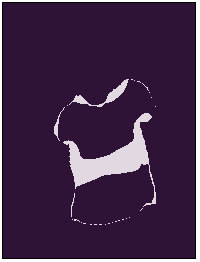

In [59]:
lt.chans(misalign[0])

In [68]:
misalign[0]

tensor[1, 256, 192] n=49152 x∈[-1.000, 0.] μ=-0.415 σ=0.493 cuda:0

In [63]:
misalign[misalign < 0.0] = 0.0

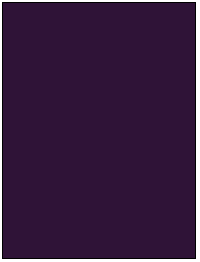

In [64]:
lt.chans(misalign[0])

In [ ]:
# labels = {
#             0:  ['background',  [0, 10]],
#             1:  ['hair',        [1, 2]],
#             2:  ['face',        [4, 13]],
#             3:  ['upper',       [5, 6, 7]],
#             4:  ['bottom',      [9, 12]],
#             5:  ['left_arm',    [14]],
#             6:  ['right_arm',   [15]],
#             7:  ['left_leg',    [16]],
#             8:  ['right_leg',   [17]],
#             9:  ['left_shoe',   [18]],
#             10: ['right_shoe',  [19]],
#             11: ['socks',       [8]],
#             12: ['noise',       [3, 11]]
#         }

In [64]:
def remove_overlap(seg_out, warped_cm):
    
    assert len(warped_cm.shape) == 4
    # background, upper, bottom만 빼고 
    warped_cm = warped_cm - (torch.cat([seg_out[:, 1:3, :, :], seg_out[:, 5:, :, :]], dim=1)).sum(dim=1, keepdim=True) * warped_cm
    return warped_cm

In [65]:
# F.softmax(fake_segmap, dim=1)
# tensor[8, 13, 256, 192] n=5111808 x∈[1.011e-13, 1.000] μ=0.077 σ=0.266 grad SoftmaxBackward0 cuda:0
warped_clothmask_paired = remove_overlap(F.softmax(fake_segmap, dim=1), warped_clothmask_paired)

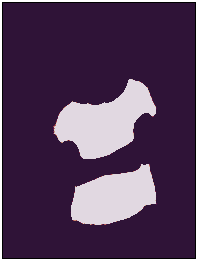

In [68]:
lt.chans(warped_clothmask_paired[0])

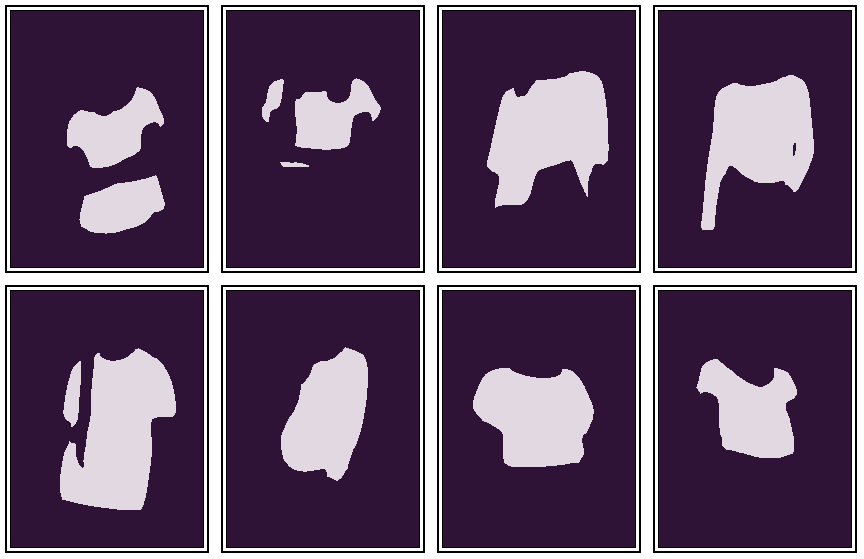

In [70]:
lt.chans(parse_cloth_mask)

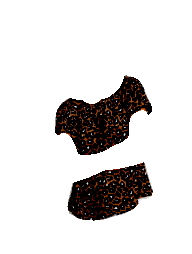

In [73]:
lt.rgb(im_c[0])

In [4]:
from network_generator import SPADEGenerator
from cp_dataset import CPDataset, CPDataLoader
from train_generator import get_opt

In [2]:
opt2 = get_opt()

In [6]:
ds = CPDataset(opt2)

In [25]:
train_loader = CPDataLoader(opt2, ds)

/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/aiteam/tykim/generative_model/human/HR-VITON/cp_dataset.py:66: RuntimeWarning: invalid value encountered in divide
  pose_data[9] = point + (pose_data[9] - point) / length_b * length_a
/home/aiteam/tykim/generative_model/human/HR-VITON/cp_dataset.py:67: RuntimeWarning: invalid value encountered in divide
  pose_data[12] = point + (pose_data[12] - point) / length_b * length_a


In [26]:
inputs = train_loader.next_batch()

In [28]:
# input1
c_paired = inputs['cloth']['paired']
cm_paired = inputs['cloth_mask']['paired']
cm_paired = torch.FloatTensor((cm_paired.detach().cpu().numpy() > 0.5).astype(np.float))
# input2
parse_agnostic = inputs['parse_agnostic']
densepose = inputs['densepose']
openpose = inputs['pose']
# GT
label_onehot = inputs['parse_onehot']  # CE
label = inputs['parse']  # GAN loss
parse_cloth_mask = inputs['pcm']  # L1
im_c = inputs['parse_cloth']  # VGG
# visualization
im = inputs['image']

/tmp/ipykernel_2181200/2392285178.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm_paired = torch.FloatTensor((cm_paired.detach().cpu().numpy() > 0.5).astype(np.float))


In [34]:
parse_agnostic.shape

torch.Size([8, 13, 1024, 768])

In [36]:
input1 = torch.cat([c_paired, cm_paired], 1)
input2 = torch.cat([parse_agnostic, densepose], 1)

In [38]:
input1.shape, input2.shape

(torch.Size([8, 4, 1024, 768]), torch.Size([8, 16, 1024, 768]))

In [46]:
flow_list, fake_segmap, warped_cloth_paired, warped_clothmask_paired = tocg(opt, input1, input2)

/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [47]:
flow_list

[tensor[8, 32, 24, 2] n=12288 x∈[-1.587, 1.890] μ=-0.004 σ=0.360 grad PermuteBackward0,
 tensor[8, 64, 48, 2] n=49152 x∈[-1.415, 1.994] μ=0.123 σ=0.360 grad AddBackward0,
 tensor[8, 128, 96, 2] n=196608 x∈[-2.781, 3.125] μ=0.101 σ=0.493 grad AddBackward0,
 tensor[8, 256, 192, 2] n=786432 x∈[-1.499, 4.667] μ=0.560 σ=0.625 grad AddBackward0,
 tensor[8, 512, 384, 2] n=3145728 x∈[-2.237, 6.130] μ=0.608 σ=0.804 grad AddBackward0]

In [48]:
warped_cm_onehot = torch.FloatTensor((warped_clothmask_paired.detach().cpu().numpy() > 0.5).astype(np.float))

/tmp/ipykernel_2181200/3123694986.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warped_cm_onehot = torch.FloatTensor((warped_clothmask_paired.detach().cpu().numpy() > 0.5).astype(np.float))


In [49]:
opt.clothmask_composition

'warp_grad'

In [51]:
cloth_mask = torch.ones_like(fake_segmap.detach())

In [52]:
warped_clothmask_paired.shape

torch.Size([8, 1, 1024, 768])

In [53]:
cloth_mask.shape

torch.Size([8, 13, 1024, 768])

In [54]:
warped_clothmask_paired.shape

torch.Size([8, 1, 1024, 768])

In [1]:
lt.chans(cloth_mask[0])

NameError: name 'lt' is not defined

In [21]:
from torch.nn import functional as F

In [22]:
pre_clothes_mask_down = F.interpolate(cm, size=(256, 192), mode='nearest')
input_parse_agnostic_down = F.interpolate(parse_agnostic, size=(256, 192), mode='nearest')
clothes_down = F.interpolate(c_paired, size=(256, 192), mode='bilinear')
densepose_down = F.interpolate(pose, size=(256, 192), mode='bilinear')

ValueError: Input and output must have the same number of spatial dimensions, but got input with with spatial dimensions of [768] and output size of (256, 192). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [4]:
generator = SPADEGenerator(opt2, 3+3+3)

In [ ]:
generator(torch.randn(1, 9, 256, 256), parse)